# Take eddy that collocated to bird data and find complete eddy history
- Read in collocated bird data
- Read in AVISO eddy database subset for NPac
- find unique eddies in bird data
- find all AVISO eddy for that eddy ID
- create new dataset with track number and observation number as dims
- save eddy data into it

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 
from geopy.distance import geodesic 
from pyresample.kd_tree import resample_nearest
from scipy import spatial

####################you will need to change some paths here!#####################
#list of input files
#list of input files

filename_aviso='F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106.nc'   #From AVISO  website
filename_bird_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc'
#################################################################################
filename_origin='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info.nc'

# read in collocated bird data

In [2]:
ds_bird = xr.open_dataset(filename_bird_netcdf)
ds_bird

<xarray.Dataset>
Dimensions:                 (index: 92738)
Coordinates:
  * index                   (index) int64 0 1 2 3 4 ... 92734 92735 92736 92737
Data variables:
    Unnamed: 0              (index) int64 ...
    Master.Key              (index) object ...
    Modified.Platform.Type  (index) object ...
    Fly.Bird.Method         (index) object ...
    Year                    (index) int64 ...
    Month                   (index) int64 ...
    Day                     (index) int64 ...
    Julian.Date             (index) int64 ...
    Sample.Area             (index) float64 ...
    PI.Credit               (index) object ...
    lon                     (index) float64 ...
    lat                     (index) float64 ...
    ANMU                    (index) int64 ...
    ARTE                    (index) int64 ...
    BLKI                    (index) int64 ...
    BOGU                    (index) int64 ...
    CAAU                    (index) int64 ...
    CAGU                    (index) int64 ...
    COLO                    (index) int64 ...
    CRAU                    (index) int64 ...
    DCCO                    (index) int64 ...
    FTSP                    (index) int64 ...
    GWGU                    (index) int64 ...
    HERG                    (index) int64 ...
    HOPU                    (index) int64 ...
    LEAU                    (index) int64 ...
    LESP                    (index) int64 ...
    MEGU                    (index) int64 ...
    NOFU                    (index) int64 ...
    PAAU                    (index) int64 ...
    PALO                    (index) int64 ...
    PIGU                    (index) int64 ...
    RHAU                    (index) int64 ...
    SAGU                    (index) int64 ...
    TUPU                    (index) int64 ...
    WHAU                    (index) int64 ...
    ALLSH                   (index) int64 ...
    ALLMU                   (index) int64 ...
    ALLBRMU                 (index) int64 ...
    GACO                    (index) int64 ...
    ALLALB                  (index) int64 ...
    ALLPE                   (index) int64 ...
    ALLJA                   (index) int64 ...
    time                    (index) datetime64[ns] ...
    amplitude               (index) float32 ...
    cyclonic_type           (index) float64 ...
    lat_eddy                (index) float32 ...
    lon_eddy                (index) float32 ...
    observation_number      (index) float64 ...
    speed_average           (index) float32 ...
    speed_radius            (index) float32 ...
    track                   (index) float64 ...
    time64                  (index) datetime64[ns] ...
    save_eddy_distance      (index) float32 ...
    aviso_adt               (index) float64 ...
    aviso_sla               (index) float64 ...
    aviso_ugos              (index) float64 ...
    aviso_ugosa             (index) float64 ...
    aviso_vgos              (index) float64 ...
    aviso_vgosa             (index) float64 ...
    ccmp_uwnd               (index) float32 ...
    ccmp_vwnd               (index) float32 ...
    cmc_sst                 (index) float32 ...
    ETOPO_depth             (index) float64 ...

# open aviso eddy dataset

In [3]:
ds_eddy = xr.open_dataset('F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106.nc')
ds_eddy = ds_eddy.rename({'latitude':'lat','longitude':'lon'})
#ds_eddy = xr.open_dataset('F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_northpac.nc')
ilen_eddy = len(ds_eddy.lat)
ds_eddy

<xarray.Dataset>
Dimensions:             (obs: 23086878)
Dimensions without coordinates: obs
Data variables:
    amplitude           (obs) float32 ...
    cyclonic_type       (obs) int8 ...
    lat                 (obs) float32 ...
    lon                 (obs) float32 ...
    observation_number  (obs) uint16 ...
    speed_average       (obs) float32 ...
    speed_radius        (obs) float32 ...
    time                (obs) object ...
    track               (obs) uint32 ...
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0

In [19]:
ds_eddy['time64']=xr.DataArray(np.empty(len(ds_eddy.lat),dtype='datetime64[ns]'), dims=('obs'))
for i,time in enumerate(ds_eddy.time.data):
    ds_eddy['time64'][i]=np.datetime64(time)

In [20]:
ds_eddy

<xarray.Dataset>
Dimensions:             (obs: 23086878)
Dimensions without coordinates: obs
Data variables:
    amplitude           (obs) float32 ...
    cyclonic_type       (obs) int8 ...
    lat                 (obs) float32 ...
    lon                 (obs) float32 ...
    observation_number  (obs) uint16 ...
    speed_average       (obs) float32 ...
    speed_radius        (obs) float32 ...
    time                (obs) object 1993-01-01 00:00:00 ... 2017-01-06 00:00:00
    track               (obs) uint32 ...
    time64              (obs) datetime64[ns] 1993-01-01 ... 2017-01-06
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0

# create a array where True when any of eddy database matches with bird collocated eddy

In [21]:
%%time
ds2 = ds_bird.where(ds_bird.track>1,drop=True)
all_tracks = np.unique(ds2.track.data)
result = ds_eddy.amplitude*np.nan
#result = [x for x in a if x in b]
a = all_tracks
b = ds_eddy.track.astype('int')
for val in a:
    result = xr.where(b==val,True,result) #,1,b) #,True,result)
print(result.sum())
ds_eddy = ds_eddy.where(result==True,drop=True)
ds_eddy

<xarray.DataArray ()>
array(102383., dtype=float32)
Wall time: 1min 4s


<xarray.Dataset>
Dimensions:             (obs: 102383)
Dimensions without coordinates: obs
Data variables:
    amplitude           (obs) float32 3.044 2.2428 3.2599 ... 4.5581 4.2677
    cyclonic_type       (obs) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    lat                 (obs) float32 58.156 58.1531 58.0991 ... 52.7487 52.7628
    lon                 (obs) float32 218.199 218.133 ... 194.587 194.577
    observation_number  (obs) float64 0.0 1.0 2.0 3.0 ... 29.0 30.0 31.0 32.0
    speed_average       (obs) float32 9.9275 8.9938 9.3274 ... 14.901 15.0704
    speed_radius        (obs) float32 91.9516 90.5198 101.973 ... 54.629 50.3442
    time                (obs) object 1993-01-01 00:00:00 ... 2016-10-31 00:00:00
    track               (obs) float64 4.438e+03 4.438e+03 ... 2.712e+05
    time64              (obs) datetime64[ns] 1993-01-01 ... 2016-10-31
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0

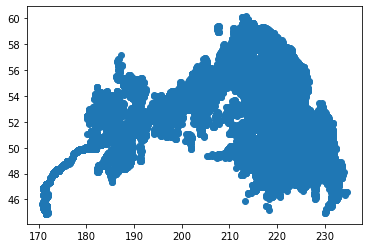

In [22]:
plt.scatter(ds_eddy.lon,ds_eddy.lat)

# Create xarray dataset structure to hold data

In [23]:
ds2 = ds_bird.where(ds_bird.track>1,drop=True)
all_tracks = np.unique(ds2.track.data)
ilen = len(all_tracks)
inum_obs = int(ds_eddy.observation_number.max().data)+1
iobs = np.arange(inum_obs)
print(ilen,inum_obs)
da=xr.DataArray(np.nan*np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy['amplitude'].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))
ds_tem = xr.Dataset({'amplitude':da})
for var in ds_eddy:
    if (var!='observation_number') & (var!='track') & (var!='time') & (var!='time64') & (var!='amplitude'):
        da=xr.DataArray(np.nan*np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy[var].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))

        ds_tem[var]=da
    if (var=='time64'):
        da=xr.DataArray(np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy[var].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))

        ds_tem[var]=da
ds_tem

765 1830


<xarray.Dataset>
Dimensions:             (observation_number: 1830, track: 765)
Coordinates:
  * track               (track) int32 4438 4918 5213 ... 270829 270892 271234
  * observation_number  (observation_number) int32 0 1 2 3 ... 1827 1828 1829
Data variables:
    amplitude           (track, observation_number) float32 nan nan ... nan nan
    cyclonic_type       (track, observation_number) float64 nan nan ... nan nan
    lat                 (track, observation_number) float32 nan nan ... nan nan
    lon                 (track, observation_number) float32 nan nan ... nan nan
    speed_average       (track, observation_number) float32 nan nan ... nan nan
    speed_radius        (track, observation_number) float32 nan nan ... nan nan
    time64              (track, observation_number) datetime64[ns] 1970-01-01 ... 1970-01-01

# go through all unique eddies and save data into structure
- save variable attributes
- save global attributes

In [24]:
for ii,idn in enumerate(ds_tem.track.data):
    subset = ds_eddy.where(ds_eddy.track.astype('int')==idn,drop=True)
    for var in subset:
        if (var!='observation_number') & (var!='track') & (var!='time') & (var!='amplitude'):
            ilen_obs = len(subset.obs)
            ds_tem[var][ii,:ilen_obs]=subset[var][:].data
            ds_tem[var].attrs=subset[var].attrs
    if subset.observation_number[0].data>0:
        print(ii,subset.observation_number[0])
ds_tem.attrs = ds_eddy.attrs
ds_tem.to_netcdf(filename_origin)

In [25]:
ds_tem

<xarray.Dataset>
Dimensions:             (observation_number: 1830, track: 765)
Coordinates:
  * track               (track) int32 4438 4918 5213 ... 270829 270892 271234
  * observation_number  (observation_number) int32 0 1 2 3 ... 1827 1828 1829
Data variables:
    amplitude           (track, observation_number) float32 nan nan ... nan nan
    cyclonic_type       (track, observation_number) float64 -1.0 -1.0 ... nan
    lat                 (track, observation_number) float32 58.156 ... nan
    lon                 (track, observation_number) float32 218.199 ... nan
    speed_average       (track, observation_number) float32 9.9275 ... nan
    speed_radius        (track, observation_number) float32 91.9516 ... nan
    time64              (track, observation_number) datetime64[ns] 1993-01-01 ... 1970-01-01
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0